In [20]:
from Params import *
from numpy import *
from PlotFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit,njit,prange
from numpy import random


#==============================================================================#
#------------------------------Coordinate trans.-------------------------------#
@jit(nopython=True)
def lab2eqt(vp,t_lab,lat):
    t = t_lab*pi/180.0
    latr = lat*pi/180.0
    v = zeros(shape=shape(vp))
    v[:,0] = -cos(t)*sin(latr)*vp[:,0] + sin(t)*vp[:,1] + cos(latr)*cos(t)*vp[:,2]
    v[:,1] = -sin(latr)*sin(t)*vp[:,0] + -cos(t)*vp[:,1] + cos(latr)*sin(t)*vp[:,2]
    v[:,2] = cos(latr)*vp[:,0] + 0*vp[:,1] + sin(latr)*vp[:,2]
    return v

@jit(nopython=True)
def eqt2gal(vp): 
    v = zeros(shape=shape(vp))
    v[:,0] = -0.066945*vp[:,0] - 0.872755*vp[:,1] - 0.483505*vp[:,2]
    v[:,1] = +0.492754*vp[:,0] - 0.450313*vp[:,1] + 0.744620*vp[:,2]
    v[:,2] = -0.867607*vp[:,0] - 0.188340*vp[:,1] + 0.460194*vp[:,2]
    return v

@jit(nopython=True)
def lab2gal(v,JD, lat, lon): 
    # Convert day into phase of Earth rotation t_lab
    UT = 24*(JD+0.5-floor(JD+0.5)) #Universal time
    MJD = JD - 2400000.5 #Modified Julian Day
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15
    t_lab = 15*t_lab #Lab time in degrees
    vp = lab2eqt(v,t_lab,lat)
    return eqt2gal(vp)
#==============================================================================#


@njit(parallel=True)
def Polarisation_costh_sq(chi_gal,Axis,t_vals,lat=45.0,lon=0.0,t0=0,Planar=False,JD_0=Jan1):
    nt = len(t_vals)
    ngen = shape(chi_gal)[0]
    costh_sq = zeros(shape=(ngen,nt))
    Axis_V = zeros(shape=(ngen,3))
    for i in prange(0,ngen):
        Axis_V[i,:] = 1*Axis
        
    for i in prange(0,nt):
        costh_sq[:,i] = sum(chi_gal*lab2gal(Axis_V,t_vals[i]+JD_0,lat,lon),1)**2
    
    if Planar:
        costh_sq = 1-costh_sq
    return costh_sq

costh2_N = Polarisation_costh_sq(zeros(shape=(100,3)),array([1,0,0]),linspace(0,1,10),45.0,0.0)

In [179]:
ngen = 1
costh_X = 2*random.uniform(size=ngen)-1
phi_X = 2*pi*random.uniform(size=ngen)
chi_gal = zeros(shape=(ngen,3))
chi_gal[:,0] = sqrt(1-costh_X**2)*cos(phi_X)
chi_gal[:,1] = sqrt(1-costh_X**2)*sin(phi_X)
chi_gal[:,2] = costh_X

lon = 0.0
lat = 45.0

Zenith = array([0,0,1])
West = array([0,1,0])
North = array([1,0,0])

T = 365.0
nt = 100
t_vals = arange(0,T,0.01)

costh2_N = Polarisation_costh_sq(chi_gal,North,t_vals,lat,lon,Planar=False)



0.08643587569613892

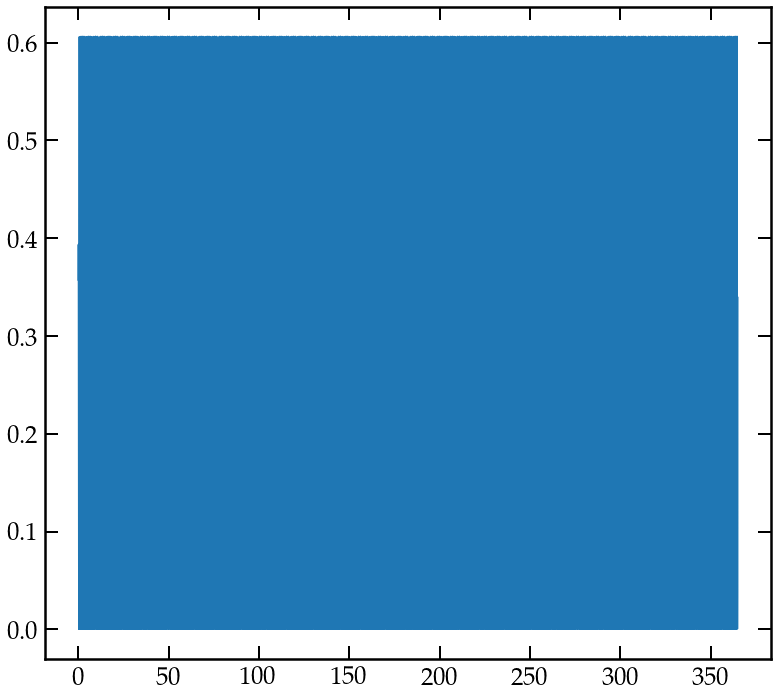

In [181]:
fig,ax = MySquarePlot()

for i in range(0,1):
    plt.plot(t_vals,costh2_N[i,:])
    
    
trapz(t_vals,costh2_N[0,:])/t_vals[-1]


100%|██████████| 365/365 [00:10<00:00, 34.32it/s]


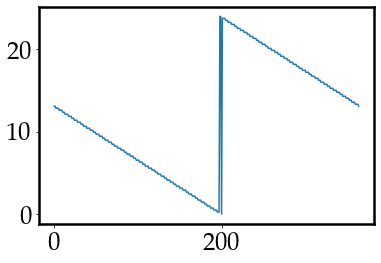

In [193]:
from tqdm import tqdm

ndays = 365
days = linspace(0,365-1,365)

nt = 100
t_vals = linspace(0,1,nt)

phase = zeros(shape=ndays)

for i in tqdm(range(0,ndays)):
    for j in range(0,nt):
        phase[i] = 24*t_vals[argmax(Polarisation_costh_sq(chi_gal,North,t_vals+days[i],lat,lon,Planar=False)[0,:])]
    
plt.plot(days,phase)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


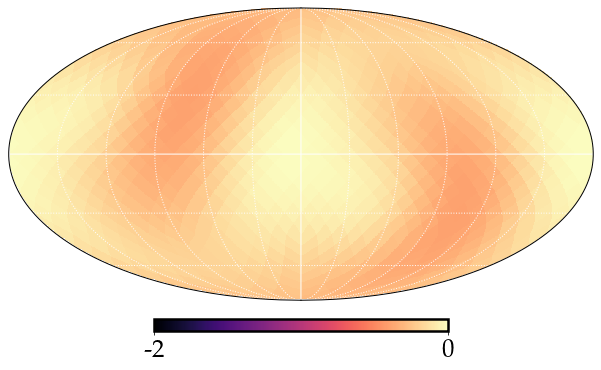

In [140]:
import healpy as hp

def chi_pix(nside):
    npix = 12*nside**2
    chi0 = zeros(shape=(npix,3))
    for i in range(0,npix):
        chi0[i,:] = array(hp.pix2vec(nside, i))
    return chi0

def llhood_costh2(t_vals,costh2_obs,costh2_exp):
    ngen = shape(costh2_exp)[0]
    nt = shape(costh2_exp)[1]
    costh2_obs_V = tile(costh2_obs,(ngen,1))
    return -trapz((costh2_obs_V-costh2_exp)**2,t_vals)

nside = 8
chi_gal = chi_pix(nside)
npix = shape(chi_gal)[0]

lon = 0.0
lat = 45.0

Zenith = array([0,0,1])
West = array([0,1,0])
North = array([1,0,0])

T = 1
nt = 1000
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,Zenith,t_vals,lat,lon,Planar=False)
L = llhood_costh2(t_vals,costh2[int(npix/2),:],costh2)
hp.mollview(L-amax(L),cmap=cm.magma,title='',min=-2)
hp.graticule(color='w')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


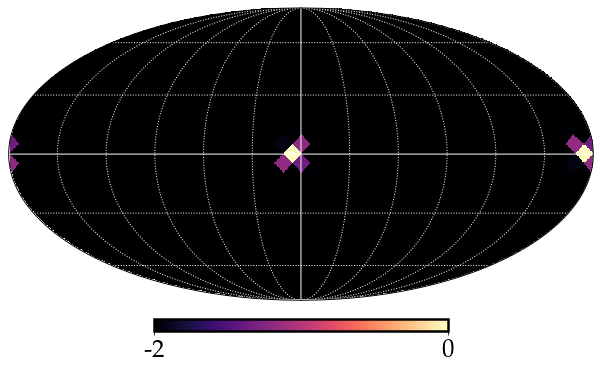

In [151]:
T = 365
nt = 4*365
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,North,t_vals,lat,lon,Planar=False)
L = llhood_costh2(t_vals,costh2[int(npix/2),:],costh2)
hp.mollview(L-amax(L),cmap=cm.magma,title='',min=-2)
hp.graticule(color='w')

0.2771185554778403


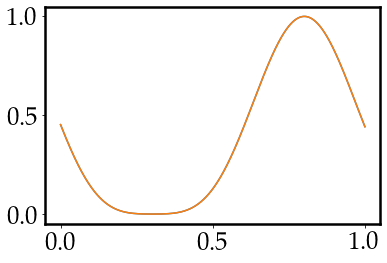

In [130]:
T = 1
nt = 1000
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,Zenith,t_vals,lat,lon,Planar=False)


Ct_obs = costh2[300,:]
Ct_true = costh2[300,:]
plt.plot(t_vals,Ct_obs)
plt.plot(t_vals,Ct_true)

L0 = trapz(Ct_true**2,t_vals)
L1 = trapz((Ct_obs-Ct_true)**2,t_vals)
print(L0)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


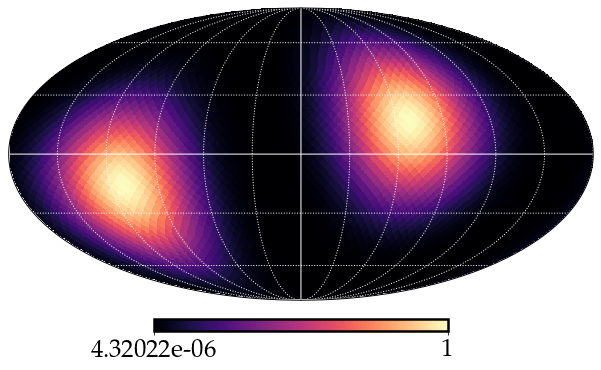

In [45]:
import healpy as hp
import matplotlib.cm as cm

T = 0.5
nt = 50
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,North,t_vals,lat,lon,Planar=False)
L = zeros(shape=npix)
for i in range(0,npix):
    costh2_obs = costh2[i,:]
    L[i] = llhood_costh2(costh2_obs,costh2)
    
hp.mollview(L/amax(L),cmap=cm.magma,title='')
hp.graticule(color='w')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


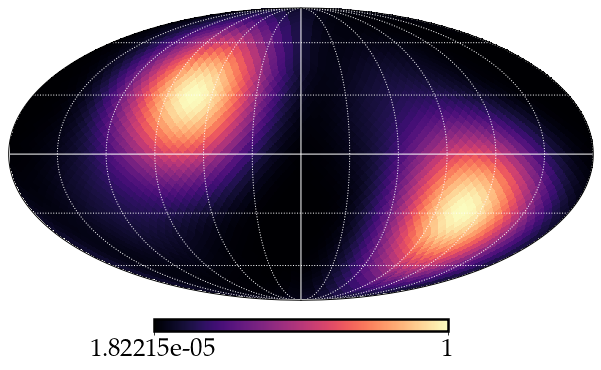

In [52]:
T = 1
nt = 50
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,North,t_vals,lat,lon,Planar=False)
L = zeros(shape=npix)
for i in range(0,npix):
    costh2_obs = costh2[i,:]
    L[i] = llhood_costh2(costh2_obs,costh2)
    
hp.mollview(L/amax(L),cmap=cm.magma,title='')
hp.graticule(color='w')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


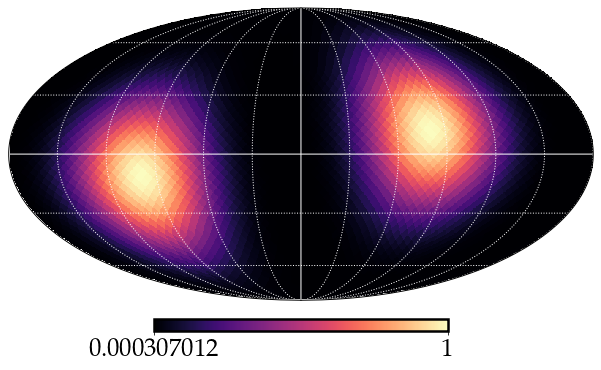

In [47]:
T = 2.0
nt = 50
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,North,t_vals,lat,lon,Planar=False)
L = zeros(shape=npix)
for i in range(0,npix):
    costh2_obs = costh2[i,:]
    L[i] = llhood_costh2(costh2_obs,costh2)
    
hp.mollview(L/amax(L),cmap=cm.magma,title='')
hp.graticule(color='w')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


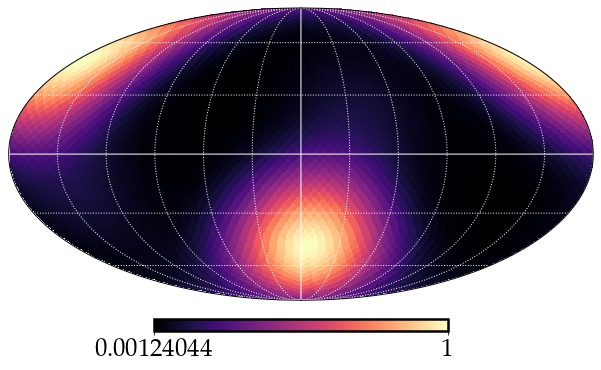

In [50]:
T = 50
nt = 50
t_vals = linspace(0,T,nt)

costh2 = Polarisation_costh_sq(chi_gal,North,t_vals,lat,lon,Planar=False)
L = zeros(shape=npix)
for i in range(0,npix):
    costh2_obs = costh2[i,:]
    L[i] = llhood_costh2(costh2_obs,costh2)
    
hp.mollview(L/amax(L),cmap=cm.magma,title='')
hp.graticule(color='w')

In [128]:
nside = 30
chi0 = chi0_pix(nside)

npix = shape(chi0)[0]
nT = 200
T = linspace(0.1,3,nT)
nbins = 100
H = zeros(shape=(nT,nbins))
C_05 = zeros(shape=nT)
C_50 = zeros(shape=nT)
C_95 = zeros(shape=nT)
C_mean = zeros(shape=nT)
for i in range(0,nT):
    costh_sq = Polarisation_costh_sq_distribution(chi0,T[i],nt=50)
    H[i,:],ce = histogram(costh_sq,nbins,range=[0,1])
    H[i,:] /= sum(H[i,:])
    sort_costh_sq = sort(costh_sq)
    C_05[i] = sort_costh_sq[int(0.05*npix)]
    C_50[i] = sort_costh_sq[int(0.5*npix)]
    C_mean[i] = mean(costh_sq)
    C_95[i] = sort_costh_sq[int(0.95*npix)]
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


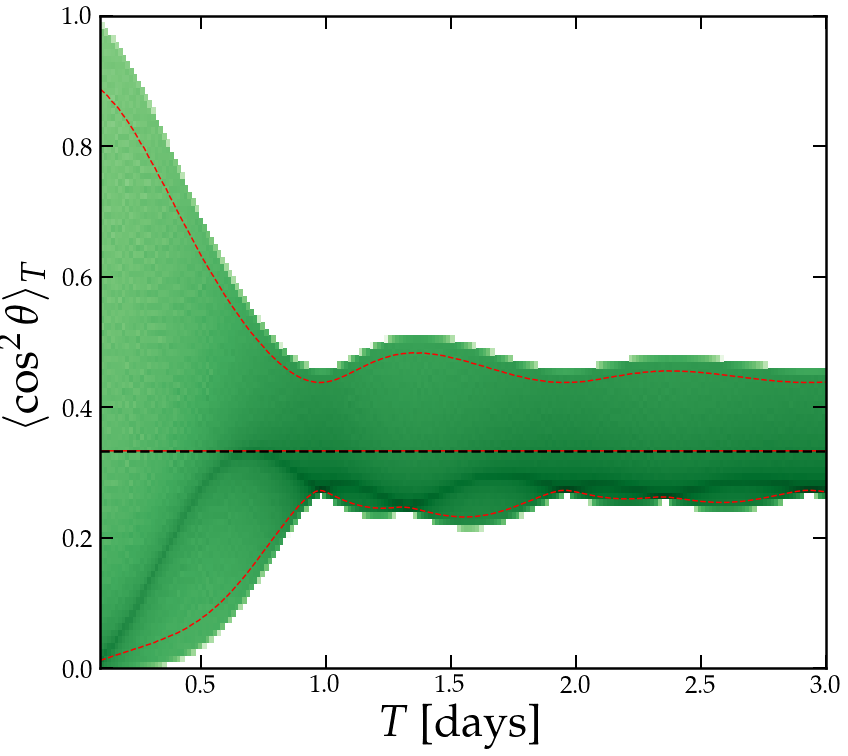

In [129]:
fig,ax = MySquarePlot(r'$T$ [days]',r'$\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = plt.pcolormesh(T,ce,log(H.T),cmap=cm.Greens)

# C_05 = zeros(shape=nT)
# C_95 = zeros(shape=nT)

# for i in range(0,nT):
#     C_05[i] = cc[argmin(abs(cumsum(H[i,:])-0.05))]
#     C_95[i] = cc[argmin(abs(cumsum(H[i,:])-0.95))]

plt.plot(T,C_05,'r--')
plt.plot(T,C_mean,'r-')
plt.plot(T,C_95,'r--')

ax.axhline(1/3,color='k',lw=2.5,linestyle='--')

In [208]:

@jit(nopython=True)
def Polarisation_costh_sq(chi0_gal,Duration,nt=50,lat=45.0,t0=0):
    lon = 0.0
    zenith = array([0,0,1])
    JD = t0+Duration+Jan1

    # Convert day into phase of Earth rotation t_lab
    UT = 24*(JD+0.5-floor(JD+0.5)) #Universal time
    MJD = JD - 2400000.5 #Modified Julian Day
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15
    t_lab = 15*t_lab #Lab time in degrees
    v0 = lab2gal(zenith,t_lab,lat)
    costh_sq = (chi0_gal[:,0]*v0[0]+chi0_gal[:,1]*v0[1]+chi0_gal[:,2]*v0[2])**2
    return costh_sq

def Polarisation_costh_dist(nside,nT,Tmax,nbins,lat):
    T = linspace(0,Tmax,nT)

    chi0 = chi0_pix(nside)
    npix = shape(chi0)[0]

    costh_sq = zeros(shape=(npix,nT))
    for i in range(0,nT):
        costh_sq[:,i] = Polarisation_costh_sq(chi0,T[i],lat=lat)

    costh_sq_mean = zeros(shape=(npix,nT))
    for i in range(0,npix):
        costh_sq_mean[i,:] = cumsum(costh_sq[i,:])/arange(1,nT+1)

    nbins = 1000
    H = zeros(shape=(nT,nbins))
    C_05 = zeros(shape=nT)
    C_50 = zeros(shape=nT)
    C_95 = zeros(shape=nT)
    C_mean = zeros(shape=nT)
    for i in range(0,nT):
        H[i,:],ce = histogram(costh_sq_mean[:,i],nbins,range=[0,1])
        H[i,:] /= sum(H[i,:])
        sort_costh_sq = sort(costh_sq_mean[:,i])
        C_05[i] = sort_costh_sq[int(0.05*npix)]
        C_50[i] = sort_costh_sq[int(0.5*npix)]
        C_mean[i] = mean(costh_sq)
        C_95[i] = sort_costh_sq[int(0.95*npix)]
    return T,ce,H,C_05,C_50,C_95
    

nT = 1000
Tmax = 3
nside = 64
nbins = 100
T,ce,H,C_05,C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,55.0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


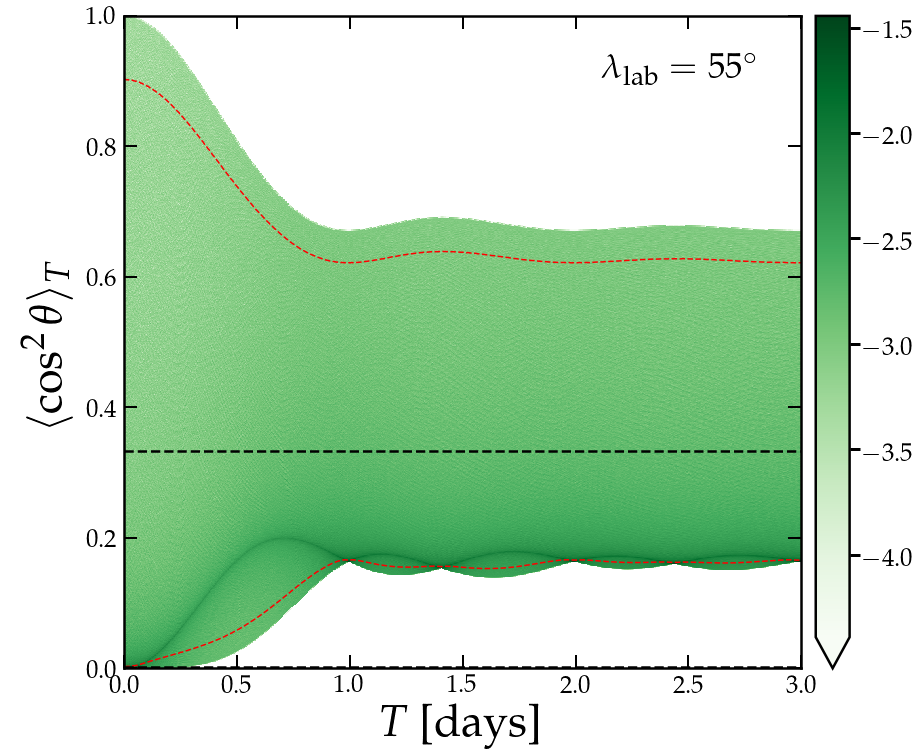

In [210]:
fig,ax = MySquarePlot(r'$T$ [days]',r'$\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = plt.pcolormesh(T,ce,log10(H.T),cmap=cm.Greens)

plt.plot(T,C_05,'r--')
plt.plot(T,C_95,'r--')

ax.axhline(1/3,color='k',lw=2.5,linestyle='--')
ax.axhline(0.0025,color='k',lw=2.5,linestyle='--')

plt.gcf().text(0.8,0.8,r'$\lambda_{\rm lab} = 55^\circ$',fontsize=35,ha='right')
plt.gcf().text(0.0,0.5,'--',zorder=0,color='w')
cbar(im,extend='min')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


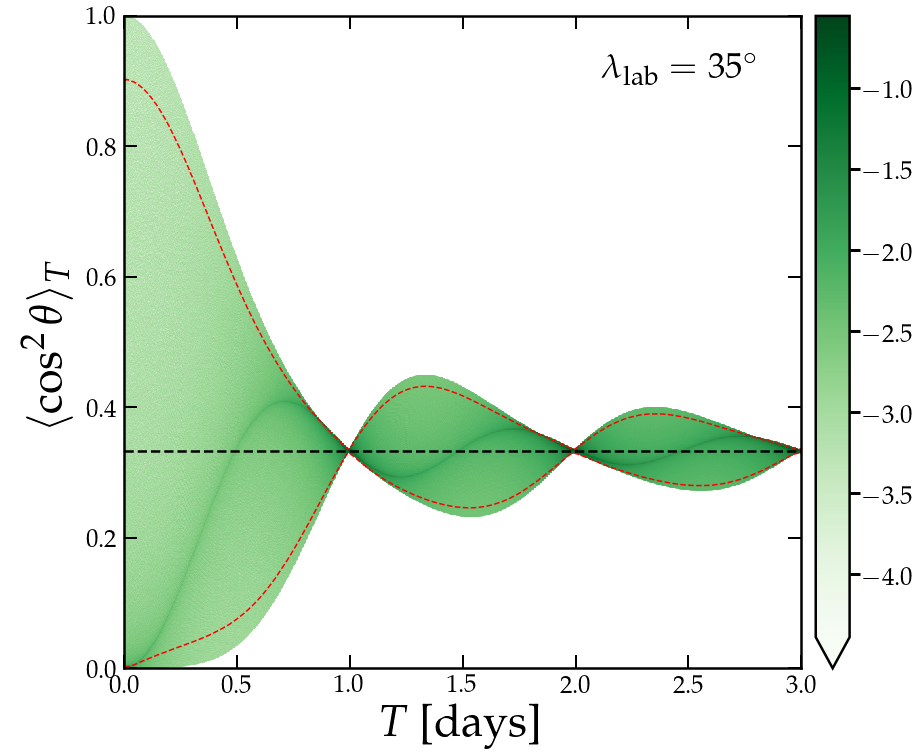

In [201]:

T,ce,H,C_05,C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,35)

fig,ax = MySquarePlot(r'$T$ [days]',r'$\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = ax.imshow(log10(flipud(H.T)),cmap=cm.Greens,extent=(0,3,0,1),aspect='auto')
plt.autoscale(False)

plt.plot(T,C_05,'r--')
plt.plot(T,C_95,'r--')

ax.axhline(1/3,color='k',lw=2.5,linestyle='--')

plt.gcf().text(0.8,0.8,r'$\lambda_{\rm lab} = 35^\circ$',fontsize=35,ha='right')
plt.gcf().text(0.0,0.5,'--',zorder=0,color='w')
cbar(im,extend='min')


pltdir = '../plots/'
pltdir_png = pltdir+'plots_png/'
#==============================================================================#
# My custom figure save
def MySaveFig(fig,pltname,pngsave=True):
    fig.savefig(pltdir+pltname+'.pdf',bbox_inches='tight')
    if pngsave:
        fig.savefig(pltdir_png+pltname+'.png',bbox_inches='tight')
#==============================================================================#


MySaveFig(fig,'costh_35')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


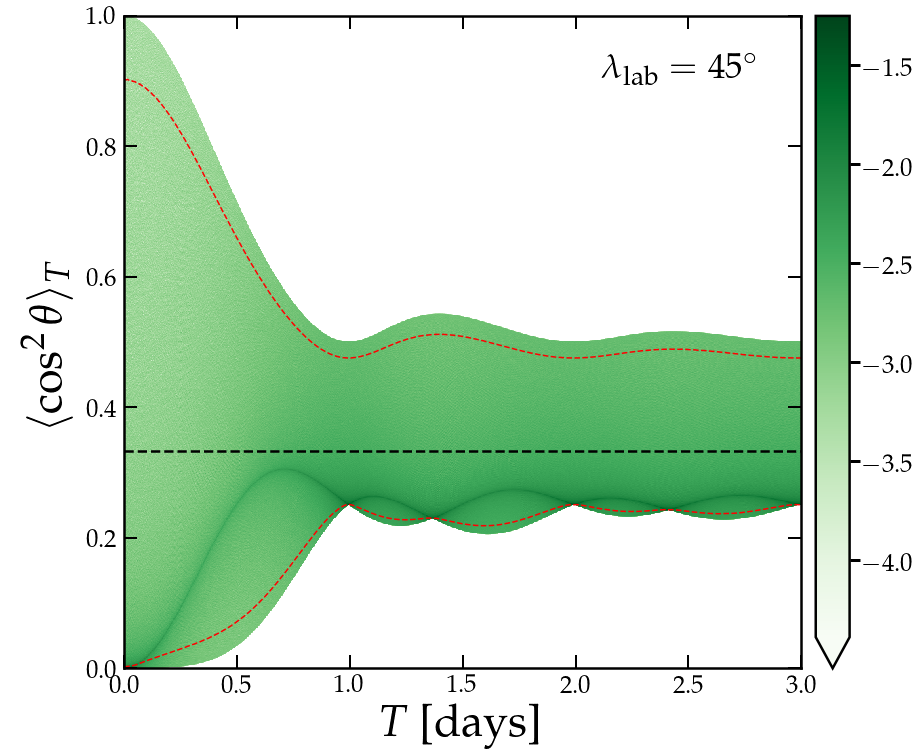

In [202]:

T,ce,H,C_05,C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,45)

fig,ax = MySquarePlot(r'$T$ [days]',r'$\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = ax.imshow(log10(flipud(H.T)),cmap=cm.Greens,extent=(0,3,0,1),aspect='auto')
plt.autoscale(False)

plt.plot(T,C_05,'r--')
plt.plot(T,C_95,'r--')

ax.axhline(1/3,color='k',lw=2.5,linestyle='--')

plt.gcf().text(0.8,0.8,r'$\lambda_{\rm lab} = 45^\circ$',fontsize=35,ha='right')
plt.gcf().text(0.0,0.5,'--',zorder=0,color='w')
cbar(im,extend='min')


pltdir = '../plots/'
pltdir_png = pltdir+'plots_png/'
#==============================================================================#
# My custom figure save
def MySaveFig(fig,pltname,pngsave=True):
    fig.savefig(pltdir+pltname+'.pdf',bbox_inches='tight')
    if pngsave:
        fig.savefig(pltdir_png+pltname+'.png',bbox_inches='tight')
#==============================================================================#


MySaveFig(fig,'costh_45')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


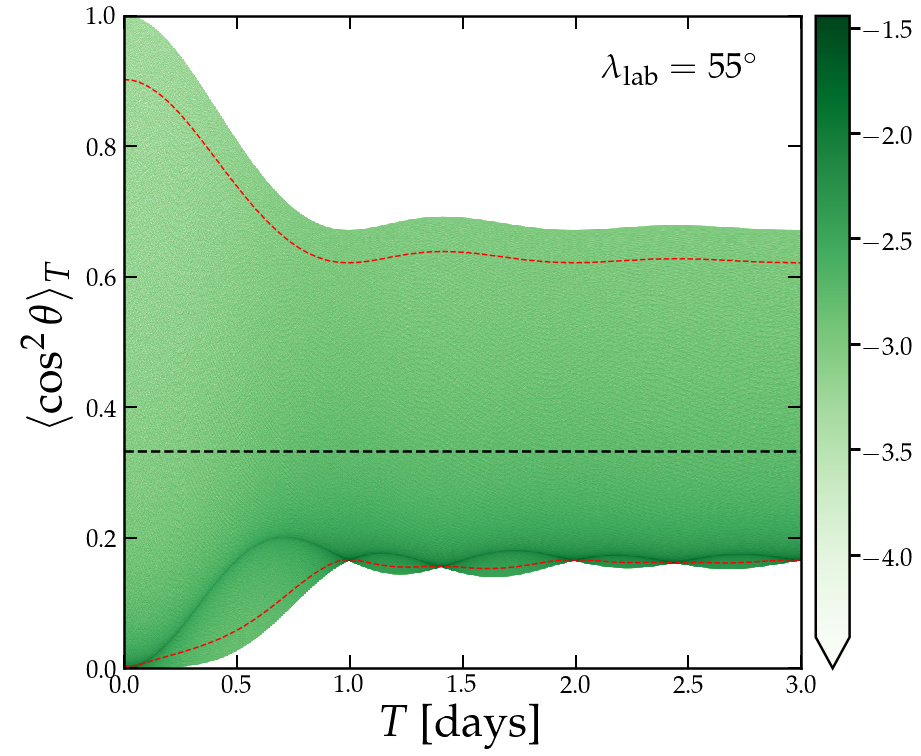

In [203]:

T,ce,H,C_05,C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,55)

fig,ax = MySquarePlot(r'$T$ [days]',r'$\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = ax.imshow(log10(flipud(H.T)),cmap=cm.Greens,extent=(0,3,0,1),aspect='auto')
plt.autoscale(False)

plt.plot(T,C_05,'r--')
plt.plot(T,C_95,'r--')

ax.axhline(1/3,color='k',lw=2.5,linestyle='--')

plt.gcf().text(0.8,0.8,r'$\lambda_{\rm lab} = 55^\circ$',fontsize=35,ha='right')
plt.gcf().text(0.0,0.5,'--',zorder=0,color='w')
cbar(im,extend='min')


pltdir = '../plots/'
pltdir_png = pltdir+'plots_png/'
#==============================================================================#
# My custom figure save
def MySaveFig(fig,pltname,pngsave=True):
    fig.savefig(pltdir+pltname+'.pdf',bbox_inches='tight')
    if pngsave:
        fig.savefig(pltdir_png+pltname+'.png',bbox_inches='tight')
#==============================================================================#


MySaveFig(fig,'costh_55')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


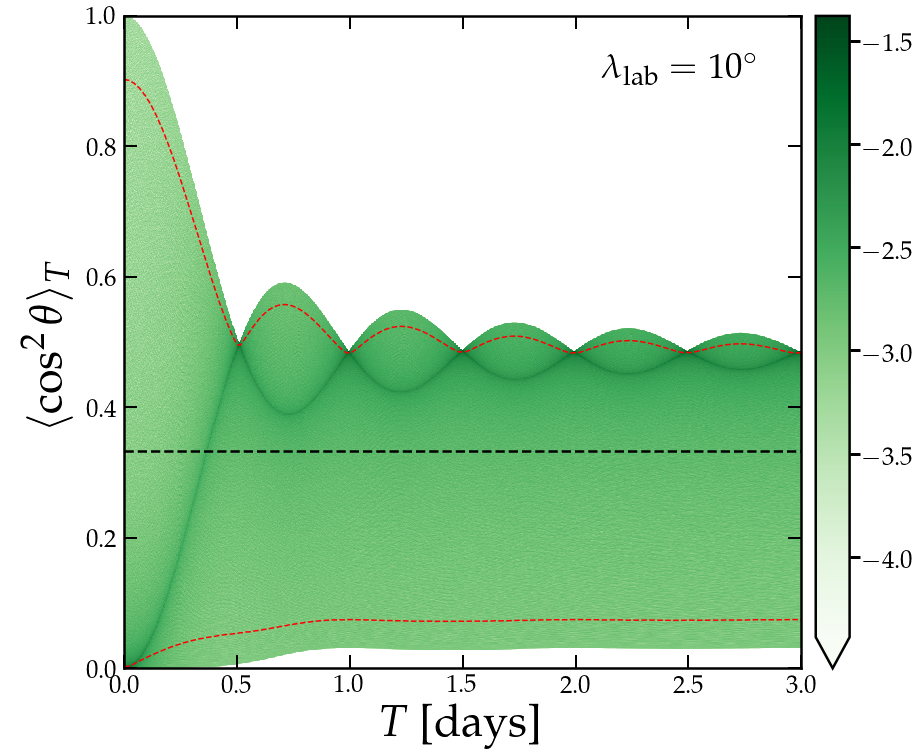

In [205]:

T,ce,H,C_05,C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,10)

fig,ax = MySquarePlot(r'$T$ [days]',r'$\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = ax.imshow(log10(flipud(H.T)),cmap=cm.Greens,extent=(0,3,0,1),aspect='auto')
plt.autoscale(False)

plt.plot(T,C_05,'r--')
plt.plot(T,C_95,'r--')

ax.axhline(1/3,color='k',lw=2.5,linestyle='--')

plt.gcf().text(0.8,0.8,r'$\lambda_{\rm lab} = 10^\circ$',fontsize=35,ha='right')
plt.gcf().text(0.0,0.5,'--',zorder=0,color='w')
cbar(im,extend='min')


pltdir = '../plots/'
pltdir_png = pltdir+'plots_png/'
#==============================================================================#
# My custom figure save
def MySaveFig(fig,pltname,pngsave=True):
    fig.savefig(pltdir+pltname+'.pdf',bbox_inches='tight')
    if pngsave:
        fig.savefig(pltdir_png+pltname+'.png',bbox_inches='tight')
#==============================================================================#


MySaveFig(fig,'costh_10')

In [268]:
from numpy import random

ngen = 100000
P = 3*random.exponential(size=ngen)
nbins = 100
Hp = zeros(shape=(nT,nbins))
P_05 = zeros(shape=nT)
P_05_0 = zeros(shape=nT)
P_med = zeros(shape=nT)
P_med_0 = zeros(shape=nT)

for i in range(0,nT):
    dist = H[i,:]
    costhsq = random.choice(cc,p=dist,size=ngen)
    Hp[i,:],pe = histogram(log10(costhsq*P),nbins,range=[-3,2])
    Hp[i,:] /= sum(H[i,:])
    
    sortP = sort(P)
    sortCP  = sort(costhsq*P)
    P_med_0[i] = sort(P)[int(0.5*ngen)]
    P_med[i] = sort(costhsq*P)[int(0.5*ngen)]
    P_05_0[i] = sort(P)[int(0.05*ngen)]
    P_05[i] = sort(costhsq*P)[int(0.05*ngen)]
    
    
T,ce,H,C_05,C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,55)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


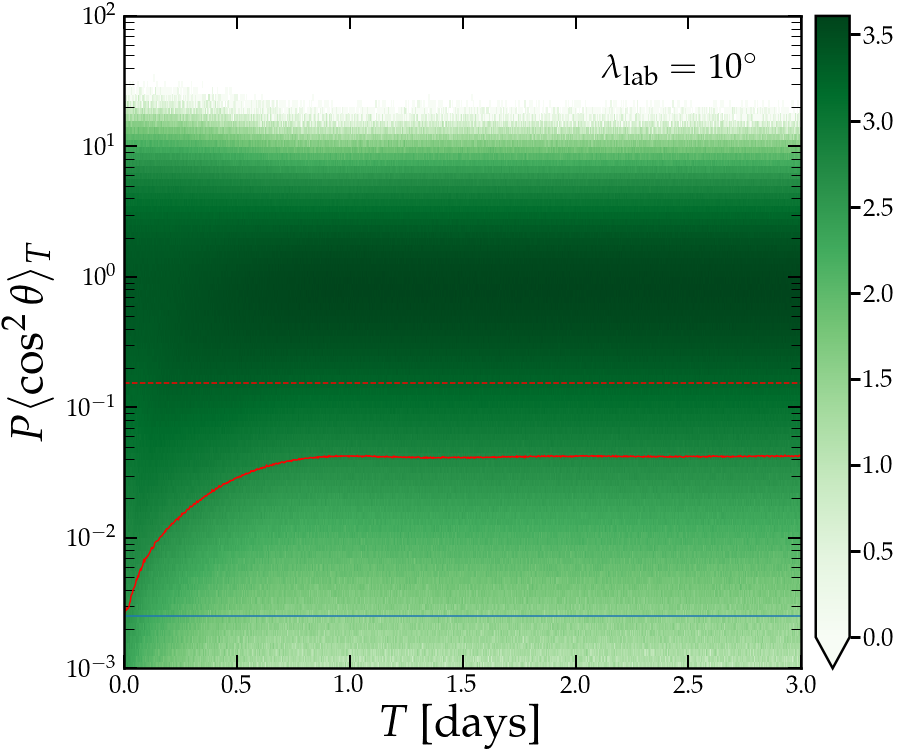

In [269]:
fig,ax = MySquarePlot(r'$T$ [days]',r'$P\langle\cos^2{\theta}\rangle_T$')
cc = (ce[1:]+ce[0:-1])/2
im = ax.pcolormesh(T,10**pe,log10(Hp.T),cmap=cm.Greens,rasterized=True)
plt.autoscale(False)

plt.yscale('log')
plt.plot(T,(P_05),'r-')
plt.plot(T,(P_05_0),'r--')

plt.axhline(0.0025)

plt.gcf().text(0.8,0.8,r'$\lambda_{\rm lab} = 10^\circ$',fontsize=35,ha='right')
plt.gcf().text(0.0,0.5,'--',zorder=0,color='w')
cbar(im,extend='min')

In [377]:
from numpy import random

@jit(nopython=True)
def AxionHP_ConversionFactor(T,H,ngen=1000000):
    nT = len(T)
    P = 3*random.exponential(size=ngen)
    P_05 = zeros(shape=nT)
    for i in range(0,nT):
        dist = H[i,:]
        costhsq = random.choice(cc,p=dist,size=ngen)
        P_05[i] = sort(costhsq*P)[int(0.05*ngen)]
    return P_05
    
nside = 30
nT = 1000
Tmax = 3
nbins = 100
lats = [30,40,50]
nloc = len(lats)
C_05 = zeros(shape=(nloc,nT))
for i in range(0,nloc):
    T,ce,H,C_05[i,:],C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,lats[i])


# P_05_1 = AxionHP_ConversionFactor(T,H1)
# P_05_2 = AxionHP_ConversionFactor(T,H2)
# P_05_3 = AxionHP_ConversionFactor(T,H3)

Text(0.5, 1.0, 'Axion $\\rightarrow$ HP limit conversion factor')

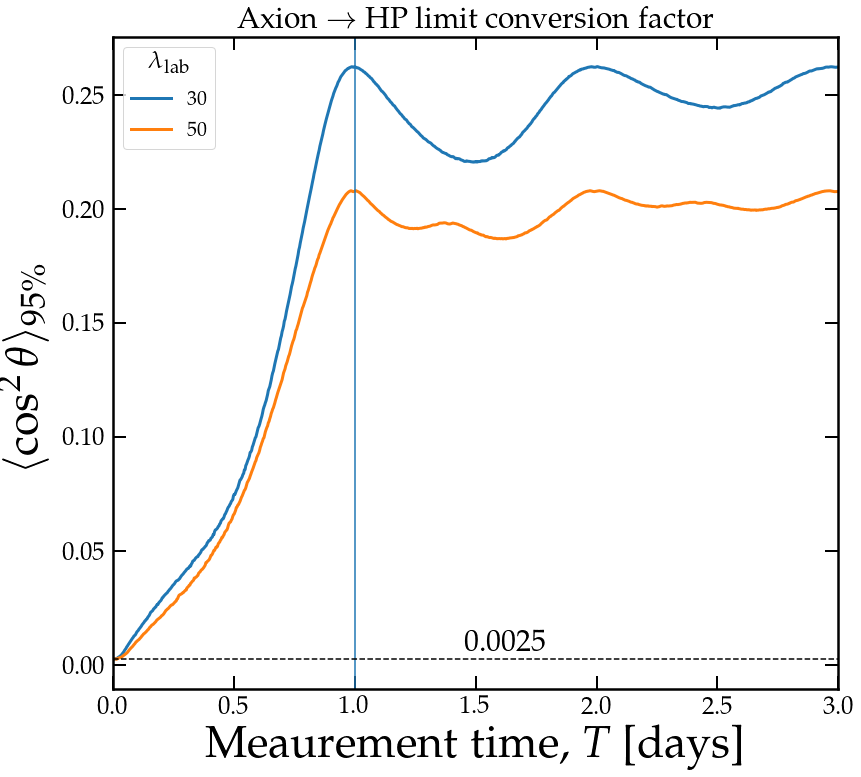

In [378]:
def smooth(a,WSZ=5):
    out0 = convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = arange(1,WSZ-1,2)
    start = cumsum(a[:WSZ-1])[::2]/r
    stop = (cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

fig,ax = MySquarePlot(r'Meaurement time, $T$ [days]',r'$\langle \cos^2{\theta}\rangle_{95\%}$')
for i in range(0,nloc):
    plt.plot(T,C_05[i,:],'-',lw=3,label=int(lats[i]))

plt.legend(title=r'$\lambda_{\rm lab}$',fontsize=20)
plt.axvline(1)
plt.axhline(0.0025,color='k',linestyle='--')
plt.gcf().text(0.5,0.17,'0.0025',fontsize=30)
plt.xlim(left=T[0],right=T[-1])
plt.title(r'Axion $\rightarrow$ HP limit conversion factor')

In [ ]:
nside = 64
nT = 1000
Tmax = 1
nbins = 100
nloc = 200
lats = linspace(-89,89,nloc)
C_05 = zeros(shape=(nloc,nT))
for i in range(0,nloc):
    T,ce,H,C_05[i,:],C_50,C_95 = Polarisation_costh_dist(nside,nT,Tmax,nbins,lats[i])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


Text(0.5, 1.0, 'Conversion factor for $n$-day long observations')

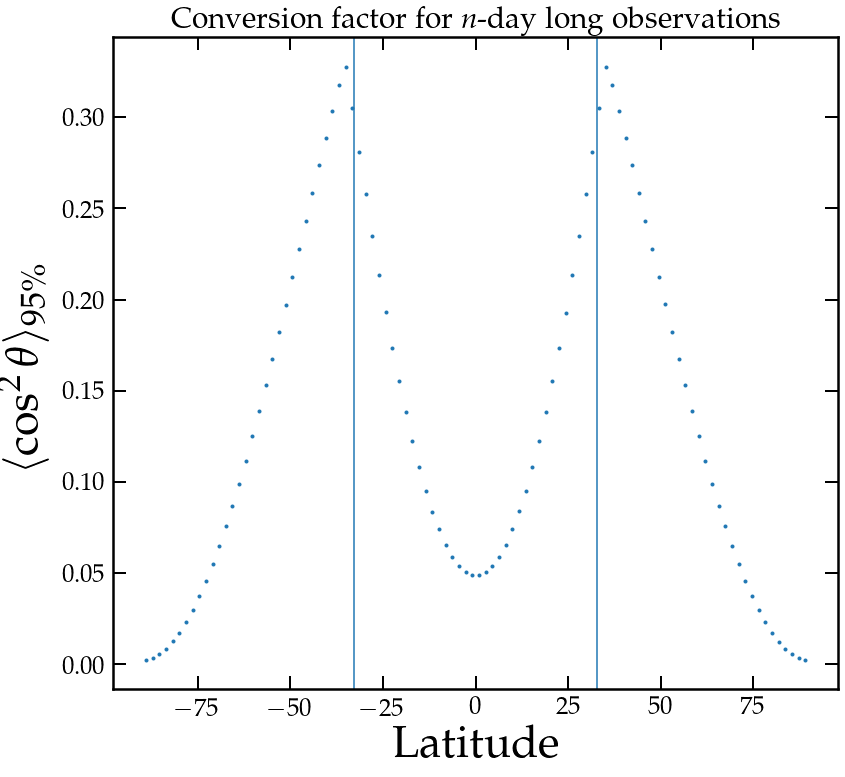

In [387]:
fig,ax = MySquarePlot('Latitude',r'$\langle \cos^2{\theta}\rangle_{95\%}$')
plt.plot(lats,C_05[:,-1],'.')
plt.axvline(90-180/pi)
plt.axvline(-(90-180/pi))
plt.title('Conversion factor for $n$-day long observations')

In [351]:
90-lats[argmax(C_05[:,-1])]

53.172413793103445

In [358]:
90-180/pi

32.70422048691768